# **А/Б тесты с метрикой отношения. Дельта-метод**

### *Код ноутбука взят из публикации X5 Tech (Хабр)*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from tqdm.notebook import tqdm

In [2]:
def plot_pvalue_distribution(dict_pvalues):
    """График распределения p-value."""
    X = np.linspace(0, 1, 1000)
    for name, pvalues in dict_pvalues.items():
        Y = [np.mean(pvalues < x) for x in X]
        plt.plot(X, Y, label=name)

    plt.plot([0, 1], [0, 1], '--k', alpha=0.8)
    plt.title('Оценка распределения p-value', size=16)
    plt.xlabel('p-value', size=12)
    plt.legend(fontsize=12)
    plt.grid()
    plt.show()

### **Метрики отношений и тест Стьюдента**

In [3]:
def generate_data(sample_size, effect):
    """Генерация данных со стоимостью покупок.
       Возвращает два списка с данными контрольной и экспериментальной групп.
       Элементы списков - множества со стоимостями покупок пользователей. 
    """
    result = []
    for group_effect in [0, effect]:
        n_purchases = np.random.randint(1, 5, sample_size)
        mean_costs = np.random.uniform(1000, 2000, sample_size)
        data = [
            np.random.normal(mean + group_effect, 200, n)
            for n, mean in zip(n_purchases, mean_costs)
        ]
        result.append(data)
    return result

In [4]:
alpha = 0.05           # допустимая вероятность ошибки I рода
sample_size = 100      # размер групп

  0%|          | 0/1000 [00:00<?, ?it/s]

Доля ошибок первого рода: 0.19


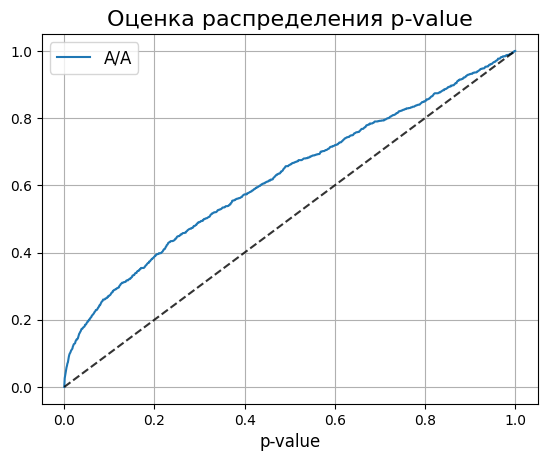

In [5]:
pvalues = []
for _ in tqdm(range(1000)):
    a, b = generate_data(sample_size, 0)
    a_values = np.hstack(a)
    b_values = np.hstack(b)
    pvalue = stats.ttest_ind(a_values, b_values).pvalue
    pvalues.append(pvalue)

error_rate = np.mean(np.array(pvalues) < alpha)
print(f'Доля ошибок первого рода: {error_rate:0.2f}')
plot_pvalue_distribution({'A/A': pvalues})

Тест Стьюдента в прошлом примере работал некорректно из-за зависимых данных. Покупки одного клиента зависимы, а покупки разных клиентов независимы. Избавимся от зависимых данных, объединив покупки по клиентам. Для каждого клиента посчитаем его средний чек и по этим данным проверим гипотезу о равенстве средних.

  0%|          | 0/1000 [00:00<?, ?it/s]

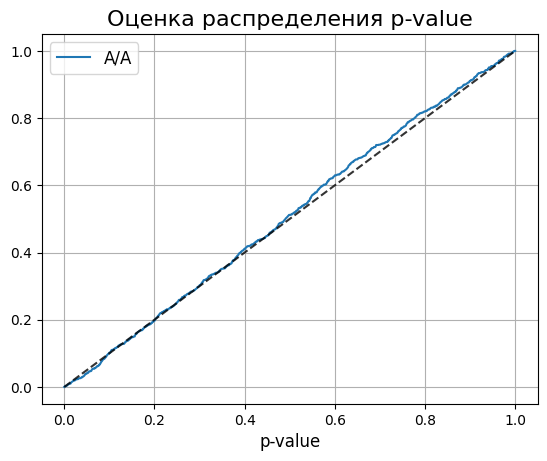

In [6]:
pvalues = []
for _ in tqdm(range(1000)):
    a, b = generate_data(sample_size, 0)
    a_means = [np.mean(x) for x in a]
    b_means = [np.mean(x) for x in b]
    pvalue = stats.ttest_ind(a_means, b_means).pvalue
    pvalues.append(pvalue)

plot_pvalue_distribution({'A/A': pvalues})

Распределение p-value получилось равномерным. Тест Стьюдента работает корректно. Но мы перешли от проверки гипотезы о равенстве метрик отношения к проверке гипотезы о равенстве среднего средних. Можно ли результаты, полученные при проверке одной гипотезы, обобщать на другую гипотезу?

Нет, между метрикой отношения и средним средних нет однозначной связи. Использовать среднее средних для проверки гипотезы о равенстве метрик отношения нельзя.

### **Бутстреп**

Основная особенность применение бутстрепа для метрик отношения — данные необходимо семплировать по объектам, а не по наблюдениям. Если объект оказался в определённой группе, то и все его действия будут в этой группе.

In [7]:
def get_percentile_ci(bootstrap_stats, alpha):
    """Перцентильный доверительный интервал."""
    left, right = np.quantile(bootstrap_stats, [alpha / 2, 1 - alpha / 2])
    return left, right

In [8]:
def check_bootsrtap(a, b, n_iter, alpha):
    """Оценка значимости отличий с помощью бутстрепа.
       Если отличия значимые, то возвращает 1, иначе 0.
    """
    # Стоимость и количество покупок клиентов
    xy_a = np.array([[sum(values), len(values)] for values in a])
    xy_b = np.array([[sum(values), len(values)] for values in b])
    # Генерация случайных индексов для выбора подмножеств данных
    len_a = len(a)
    len_b = len(b)
    indexes_a = np.random.choice(
        np.arange(len_a), size=(n_iter, len_a), replace=True
    )
    indexes_b = np.random.choice(
        np.arange(len_b), size=(n_iter, len_b), replace=True
    )

    bootstrap_stats = []
    for idx_a, idx_b in zip(indexes_a, indexes_b):
        bootstrap_xy_a = xy_a[idx_a]
        bootstrap_xy_b = xy_b[idx_b]
        # Разница метрик отношения
        bootstrap_stat = (
            bootstrap_xy_b[:, 0].sum() / bootstrap_xy_b[:, 1].sum()
            - bootstrap_xy_a[:, 0].sum() / bootstrap_xy_a[:, 1].sum()
        )
        bootstrap_stats.append(bootstrap_stat)
    # Доверительный интервал и оценка значимости отличий
    ci = get_percentile_ci(bootstrap_stats, alpha)
    has_effect = 1 - (ci[0] < 0 < ci[1])
    return has_effect

In [9]:
alpha = 0.05               # допустимая вероятность ошибки I рода
sample_size = 1000         # размер групп
n_iter = 1000              # количество итераций бутстрепа

In [10]:
effects = []
for _ in tqdm(range(1000)):
    a, b = generate_data(sample_size, 0)
    has_effect = check_bootsrtap(a, b, n_iter, alpha)
    effects.append(has_effect)

error_rate = np.mean(np.array(effects) == 1)
print(f'Доля ошибок первого рода: {error_rate:0.3f}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Доля ошибок первого рода: 0.047


Приведённая реализация бутстрепа не вычисляет p-value, поэтому построить распределение мы не сможем. Доля ошибок первого рода находится в районе заданного уровня значимости.

### **Дельта-метод**

In [11]:
def check_delta_method(a, b):
    """Проверка гипотезы с помощью дельта-метода.
       Возвращает p-value.
    """
    dict_ = {}
    for data, group_name in [(a, 'a',), (b, 'b',)]:
        n_user = len(data)
        array_x = np.array([np.sum(row) for row in data])
        array_y = np.array([len(row) for row in data])
        mean_x, mean_y = np.mean(array_x), np.mean(array_y)
        var_x, var_y = np.var(array_x), np.var(array_y)
        cov_xy = np.cov(array_x, array_y)[0, 1]
        # Точечная оценка метрики
        pe_metric = np.sum(array_x) / np.sum(array_y)
        # Оценка дисперсии метрики
        var_metric = (
            var_x / mean_y ** 2
            - 2 * (mean_x / mean_y ** 3) * cov_xy
            + (mean_x ** 2 / mean_y ** 4) * var_y
        ) / n_user
        dict_[f'pe_metric_{group_name}'] = pe_metric
        dict_[f'var_metric_{group_name}'] = var_metric
    var = dict_['var_metric_a'] + dict_['var_metric_b']
    delta = dict_['pe_metric_b'] - dict_['pe_metric_a']
    t = delta / np.sqrt(var)
    pvalue = (1 - stats.norm.cdf(np.abs(t))) * 2
    return pvalue

In [12]:
alpha = 0.05           # допустимая вероятность ошибки I рода
sample_size = 1000     # размер групп
effect = 50            # размер эффекта

  0%|          | 0/1000 [00:00<?, ?it/s]

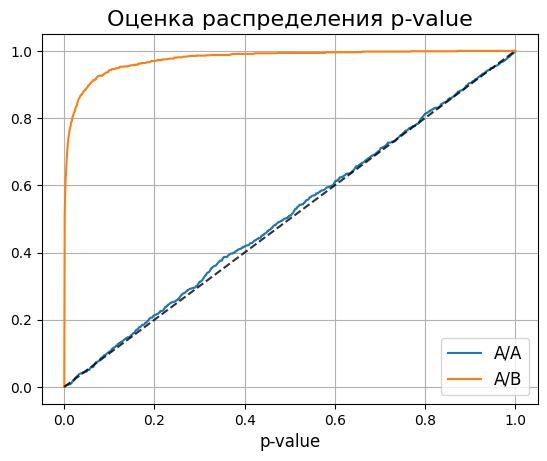

In [13]:
pvalues_aa = []
pvalues_ab = []
for _ in tqdm(range(1000)):
    a, b = generate_data(sample_size, 0)
    pvalues_aa.append(check_delta_method(a, b))
    a, b = generate_data(sample_size, effect)
    pvalues_ab.append(check_delta_method(a, b))

plot_pvalue_distribution({'A/A': pvalues_aa, 'A/B': pvalues_ab})

В этот раз мы провели и А/А и А/Б эксперименты. Дельта-метод контролирует вероятность ошибки первого рода на уровне значимости, когда эффекта нет, и находит эффект, когда он есть. Критерий работает корректно.

**Выводы**

* Критерий Стьюдента, применённый в лоб к исходным данным, работает некорректно, так как данные зависимы.

* Если заменить метрику отношения на среднее средних, то проблема зависимых данных исчезнет, но новая метрика может быть не сонаправлена с исходной. Если увеличилась одна, то другая могла как увеличиться, так и уменьшиться.

* Оценить значимость изменения метрики отношения можно с помощью бутстрепа. Основной недостаток — требует много вычислительных ресурсов.

* Дельта-метод — способ оценки А/Б тестов с метрикой отношения, который основан на вычислении дисперсии зависимых данных.